# Load lib

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import pandas as pd

In [61]:
# select computational device among cpu and gpu
device = torch.device('cuda:0' if not torch.cuda.is_available() else 'cpu')

# Load Data

## data loader

In [62]:
import pandas as pd
import os
import numpy as np

# this class allow us to prepare data to be suitable for our model
class Dataset(Dataset):
    
    def __init__(self, data ):
        training_data = data
        training_data = training_data.astype(np.float32)
        self.training_data = training_data
        
    def __len__(self):
        return len(self.training_data)
    
    def __getitem__(self,index):
        elem = self.training_data.iloc[index][1:-1]
        elem = np.array(list(elem),dtype=np.float64)
        target = self.training_data.iloc[index][-1]
        return elem , target
    

In [63]:
# create data loader for batch creation , data loader take as input the output of Dataset created above
def create_dataset(data , batch_size = 64):
    data_builder = Dataset(data)
    data_loader = DataLoader(data_builder,
                             shuffle=False,
                             batch_size=batch_size,
                             pin_memory=True)
    return data_loader

In [64]:
# load train and test data from csv file
old_data = True
if old_data :
    train_data_mae = pd.read_csv("./data/TE_fault_detection/preprocesed/train_simulated_data.csv")
    test_data_mae = pd.read_csv("./data/TE_fault_detection/preprocesed/test_simulated_data.csv")
else :
    train_data_mae = pd.read_csv('./data/te_dataset_from_net/preprocessed/tep_training_data.csv')
    test_data_mae = pd.read_csv('./data/te_dataset_from_net/preprocessed/tep_testing_data.csv')
    train_data_mae = train_data_mae.rename(columns={"faultNumber": "fault_type"})
    train_data_mae = train_data_mae[train_data_mae.fault_type != 14]
    train_data_mae.drop(['Unnamed: 0'],axis=1,inplace=True)
    test_data_mae.drop(['Unnamed: 0'],axis=1,inplace=True)

In [65]:
train_data_mae

,Time,Stream9Valve,Stream10Valve,Stream11Valve,ReactorcCoolingWaterValve,CondenserCoolingWaterValve,Stream1,Stream2,Stream3,Stream4,...,Stream9E,Stream9F,Stream9G,Stream9H,Stream11D,Stream11E,Stream11F,Stream11G,Stream11H,fault_type
0,0.00,0.392957,0.389447,0.521214,0.413615,0.366509,0.985358,0.449006,0.465549,0.470248,...,0.152994,0.687998,0.748791,0.698560,0.376679,0.104672,0.551524,0.400161,0.698384,0
1,0.01,0.422697,0.450481,0.597365,0.413111,0.305307,0.985487,0.567823,0.518101,0.292870,...,0.152994,0.687998,0.748791,0.698560,0.376679,0.104672,0.551524,0.400161,0.698384,0
2,0.02,0.369566,0.441659,0.454134,0.411814,0.297345,0.986094,0.519516,0.472278,0.097639,...,0.152994,0.687998,0.748791,0.698560,0.376679,0.104672,0.551524,0.400161,0.698384,0
3,0.03,0.473114,0.448156,0.649004,0.415477,0.464556,0.982438,0.589684,0.432008,0.426098,...,0.152994,0.687998,0.748791,0.698560,0.376679,0.104672,0.551524,0.400161,0.698384,0
4,0.04,0.321950,0.354038,0.303026,0.407748,0.421551,0.981361,0.378670,0.425483,0.554736,...,0.152994,0.687998,0.748791,0.698560,0.376679,0.104672,0.551524,0.400161,0.698384,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3496,34.96,0.370671,0.659183,0.587846,0.314286,0.611557,0.981783,0.453501,0.522783,0.309558,...,0.653506,0.184191,0.270310,0.406773,0.502422,0.593534,0.594888,0.383899,0.590797,0
3497,34.97,0.383456,0.354810,0.564780,0.314470,0.666304,0.990733,0.503321,0.413795,0.440631,...,0.653506,0.184191,0.270310,0.406773,0.502422,0.593534,0.594888,0.383899,0.590797,0
3498,34.98,0.443102,0.519865,0.416200,0.316268,0.532712,0.987504,0.501689,0.401466,0.826645,...,0.653506,0.184191,0.270310,0.406773,0.502422,0.593534,0.594888,0.383899,0.590797,0
3499,34.99,0.481526,0.413765,0.465103,0.314830,0.284495,0.985573,0.391307,0.421103,0.310832,...,0.653506,0.184191,0.270310,0.406773,0.502422,0.593534,0.594888,0.383899,0.590797,0


In [66]:
# train_data_mae.drop(['Unnamed: 0'],axis=1,inplace=True)
#train_data_copy = train_data_mae.copy()

sample_start = 0
fault_data_size = len(train_data_mae)
apply_rate_change = 1
if apply_rate_change :
    train_data_normal = train_data_mae[train_data_mae.fault_type == 0]
    train_data_fault1 = train_data_mae[train_data_mae.fault_type == 1][0:fault_data_size]
    train_data_fault2 = train_data_mae[train_data_mae.fault_type == 2][0:fault_data_size]
    train_data_fault3 = train_data_mae[train_data_mae.fault_type == 3][0:fault_data_size]
    
    train_data_mae = pd.concat([train_data_normal,train_data_fault1,train_data_fault2,train_data_fault3])
    train_data_mae = train_data_mae.sample(frac=1).reset_index().drop(['index'],axis=1)
    
    train_data_f = pd.concat([train_data_normal[:fault_data_size],train_data_fault1,train_data_fault2,train_data_fault3])
    train_data_f = train_data_mae.sample(frac=1).reset_index().drop(['index'],axis=1) 
    

In [67]:
#train_kown_class_loader = create_dataset(train_all_data)
if apply_rate_change :
    train_data_normal_loader = create_dataset(train_data_normal)
    train_data_fault1_loader = create_dataset(train_data_fault1)
    train_data_fault2_loader = create_dataset(train_data_fault2)
    train_data_fault3_loader = create_dataset(train_data_fault3)

    train_data_loader_f = create_dataset(train_data_f,batch_size=64)
if old_data :
    train_data_loader_n = create_dataset(train_data_mae,batch_size=64)
else :
    train_data_mae = train_data_mae.sample(frac=1).reset_index().drop(['index'],axis=1)
    train_data_mae = train_data_mae[train_data_mae.fault_type == 0]

In [68]:
len(train_data_mae.columns)

48

## Utils

In [69]:
import seaborn as sns
from sklearn.metrics import confusion_matrix , f1_score

# we use this function for plotting confusion matrix
def plot_confusion_matrix(y_pred, y_true) :
    cf_matrix = confusion_matrix( y_pred , y_true)
    # plt.figure(figsize = (15,7))
    fig = sns.heatmap(cf_matrix , annot=True ,fmt = ".0f", cmap='Blues' , annot_kws={"size": 10})
    plt.xlabel("True Class")
    plt.ylabel("Predicted Class")
    plt.title("Confusion matrix") 
    plt.show(fig)

# Model

In [70]:
# Define our experimental model , Autoencoder and Variational Autoencoder
class Autoencoder(nn.Module) :
    def __init__(self):
        super().__init__()
        size_in = 46
        size_hidden_1 = 54
        size_hidden_2 = 78
        size_hidden_3 = 96
        size_latent_space = 92
        dropout_proba = 0.0
        self.encoder = nn.Sequential(
             nn.Linear(size_in , size_hidden_1 ) ,
             nn.ReLU() ,
             #nn.LeakyReLU(0.1) ,
             nn.Dropout(dropout_proba) ,
             nn.Linear(size_hidden_1, size_hidden_2) ,
             nn.ReLU(),
             #nn.LeakyReLU(0.1) ,
             nn.Dropout(dropout_proba) ,
             nn.Linear(size_hidden_2,size_latent_space) 
             )
        
        self.decoder = nn.Sequential(
             nn.Linear(size_latent_space, size_hidden_2) , 
             nn.ReLU() ,
             nn.Dropout(dropout_proba) ,
             nn.Linear(size_hidden_2, size_hidden_1) ,
             nn.ReLU() ,
             nn.Dropout(dropout_proba) ,
             nn.Linear(size_hidden_1, size_in), 
             )
    
    def forward(self, x) :
        z = self.encoder(x)
        decoded = self.decoder(z)
        return decoded , z

class VariationalAutoEncoder(nn.Module) :
    def __init__(self):
        size_in = 46
        size_hidden_1 = 54
        size_hidden_2 = 78
        size_hidden_3 = 96
        size_latent_space = 92
        super().__init__()
        self.encoder = nn.Sequential(
             nn.Linear(size_in, size_hidden_1 ) , 
             nn.ReLU() ,
             nn.Linear(size_hidden_1, size_hidden_2) ,
             nn.ReLU(),
             nn.Linear(size_hidden_2,size_latent_space) 
             )
        
        self.linear2 = nn.Linear(size_latent_space, size_latent_space)
        self.linear3 = nn.Linear(size_latent_space, size_latent_space)
        
        self.N = torch.distributions.Normal(0, 1)
        self.kl = 0
        
        self.decoder = nn.Sequential(
             nn.Linear(size_latent_space, size_hidden_2) ,
             nn.ReLU() ,
             nn.Linear(size_hidden_2, size_hidden_1) ,
             nn.ReLU() ,
             nn.Linear(size_hidden_1,size_in), 
             )
        
    def reparameterize(self,mu,sigma):
        std = torch.exp(0.5*sigma)
        eps = torch.randn_like(std)
        z = (mu + eps*std)
        return z
    
    def forward(self, x) :
        x = self.encoder(x)
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        
        z = mu + sigma*self.N.sample(mu.shape)
        #z = self.reparameterize(mu,sigma)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        #self.kl = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())
        decoded = self.decoder(z)
        return decoded , z    

In [71]:
# define cost function 
def criterion(elem,recon,model , model_type="AE",bias_in_wrong_class=None,mode='test') :
    # L2 regularization coefficient 
    l2_lambda = 0.01
    l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
    L2_regularization = l2_lambda*l2_norm
    if model_type == "VAE" :
        if mode == 'test':
            loss = ((elem - recon)**2).sum() 
        elif mode == 'train' :
            recon  = recon + bias_in_wrong_class[:,None]
            loss = ((elem - recon)**2).sum() + 0.09*model.kl + L2_regularization
    elif model_type == "AE" :
        if mode == 'test' :
            loss = ((elem - recon)**2).sum()
        elif mode == 'train' :
            recon  = recon + bias_in_wrong_class[:,None] 
            loss = ((elem - recon)**2 ).sum() + L2_regularization
    return loss

# train model

In [72]:
# model trainer : create training phase routine for all instance of autoencoder or variational autoencoder
def train(train_data_loader,Model,model_type,model_num,num_epochs = 30):
    optimizer = torch.optim.Adam(Model.parameters() , lr=1e-3 , weight_decay=1e-5 )
    outputs = []
    show_elem = None
    for epoch in range(num_epochs) :
        for elem , target in train_data_loader :
            elem = elem.to(device)
            recon = Model(elem)[0]
            bias_in_wrong_class = torch.where(target==model_num,0,1.9).to(device)
            loss = criterion(recon,elem,Model,model_type=model_type,bias_in_wrong_class=bias_in_wrong_class,mode='train')
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0 :
            print(f"epoch : {epoch +1} , loss : {loss.item():4f}")
        outputs.append((epoch, elem, recon))
    return Model

# Variational Auto encoders 

### define model 

In [73]:
class Model :
    def __init__(self,mode="AE"):
        self.mode = mode
        self.minmax_rloss_train_data = ()
        self.normalizing = False
        
        if self.mode == "AE":
            self.model = Autoencoder().double().to(device)
        elif self.mode == "VAE":
            self.model = VariationalAutoEncoder().double().to(device)

    def load(self,model_path):
        saved_model = torch.load(model_path)
        self.model.load_state_dict(saved_model)

    def save(self,PATH="./trained_models/trained_model.pt"):
        # save model 
        torch.save({'vae': mae.models[0].state_dict()}, PATH)
    
    def train(self, data_loaders , n_epochs):
        self.model = train(data_loaders,self.model,model_type=self.mode,model_num=0,num_epochs=n_epochs)
    
    def compute_recon_minmax(self,train_data,new_model=False):
        data_loader = create_dataset(train_data,batch_size=1)
        r_loss = [criterion(self.model(data_point)[0],data_point,self.model,model_type=self.mode).detach().numpy().item()  for data_point, _ in data_loader ]
        self.minmax_rloss_train_data = (min(r_loss),max(r_loss))

    def predict(self, data_point, threshold = 1, detect_new_class = False):
        
        # normalize ( if normalizing variable is True ) reconstruction loss with min and max of training data 
        model = self.model
        loss = criterion(model(data_point)[0],data_point,model,model_type=self.mode).detach().numpy().item()
        if len(self.minmax_rloss_train_data) > 0 and self.normalizing :
            max_loss = self.minmax_rloss_train_data[1]
            min_loss = self.minmax_rloss_train_data[0]
            minmax_func = lambda loss : (loss - min_loss) / (max_loss - min_loss)
            loss = minmax_func(loss)
        
        pred = None
        # get the expected class by argmin of reconstruction loss 
        if loss < threshold    :
            pred = 0
        else :
            pred = 1
        
        return loss , pred


In [74]:
data_loaders = train_data_normal_loader

model = Model(mode="AE")
load = True
if load :
    model.load("explanable_autoencoder")
Train = not load
if Train :
    model.train(data_loaders,500)

In [75]:
save = not load
if save :
    torch.save(model.model.state_dict(), "explanable_Variationnal_autoencoder")

## search threshold

## test model

In [76]:
normalize = False
if normalize :
    model.compute_recon_minmax(train_data_mae)
    model.normalizing = True
else :
    model.minmax_rloss_train_data = []
    model.normalizing = False

In [77]:
test_data_mae

,Time,Stream9Valve,Stream10Valve,Stream11Valve,ReactorcCoolingWaterValve,CondenserCoolingWaterValve,Stream1,Stream2,Stream3,Stream4,...,Stream9E,Stream9F,Stream9G,Stream9H,Stream11D,Stream11E,Stream11F,Stream11G,Stream11H,fault_type
0,0.00,0.392957,0.389447,0.521214,0.413615,0.366509,0.985358,0.449006,0.465549,0.470248,...,0.152994,0.687998,0.748791,0.698560,0.376679,0.104672,0.551524,0.400161,0.698384,0
1,0.01,0.422240,0.181379,0.505731,0.410477,0.422845,0.986796,0.189955,0.434255,0.303059,...,0.152994,0.687998,0.748791,0.698560,0.376679,0.104672,0.551524,0.400161,0.698384,0
2,0.02,0.444556,0.372124,0.464457,0.416332,0.484432,0.987155,0.109436,0.638892,0.751183,...,0.152994,0.687998,0.748791,0.698560,0.376679,0.104672,0.551524,0.400161,0.698384,0
3,0.03,0.396940,0.420815,0.655230,0.416889,0.354435,0.979255,0.376131,0.390753,0.426758,...,0.152994,0.687998,0.748791,0.698560,0.376679,0.104672,0.551524,0.400161,0.698384,0
4,0.04,0.383609,0.237584,0.548601,0.411895,0.309447,0.984272,0.449467,0.613754,0.256492,...,0.152994,0.687998,0.748791,0.698560,0.376679,0.104672,0.551524,0.400161,0.698384,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1796,17.96,0.385840,0.533050,0.323472,0.385729,0.533747,0.975542,0.486820,0.574380,0.387350,...,0.311075,0.473592,0.559607,0.604947,0.337553,0.247240,0.696414,0.413389,0.664182,0
1797,17.97,0.424981,0.337545,0.410975,0.389384,0.186056,0.988016,0.270691,0.595461,0.468285,...,0.311075,0.473592,0.559607,0.604947,0.337553,0.247240,0.696414,0.413389,0.664182,0
1798,17.98,0.406368,0.439720,0.368663,0.392587,0.414594,0.984444,0.746269,0.597280,0.598047,...,0.311075,0.473592,0.559607,0.604947,0.337553,0.247240,0.696414,0.413389,0.664182,0
1799,17.99,0.437853,0.327850,0.362450,0.392858,0.411919,0.993416,0.464943,0.394692,0.575368,...,0.311075,0.473592,0.559607,0.604947,0.337553,0.247240,0.696414,0.413389,0.664182,0


In [78]:
#test_data_maeX , test_data_maeY = test_data_mae.drop(['Unnamed: 0'],axis=1) , test_data_mae['fault_type']
if old_data :
    test_data_mae = pd.read_csv("./data/TE_fault_detection/preprocesed/test_simulated_data.csv")
    test_data_mae = test_data_mae[test_data_mae.index <= 1200]
else :
    test_data_mae = pd.read_csv('./data/te_dataset_from_net/preprocessed/tep_testing_data.csv')
    test_data_mae = test_data_mae.rename(columns={"faultNumber" : "fault_type"})
    test_data_mae = test_data_mae[test_data_mae.fault_type != 14]
    test_data_mae.drop(['Unnamed: 0'],axis=1,inplace=True)

In [79]:
#test_data_mae = test_data_mae[test_data_mae.index <= 1200]
test_data_mae['fault_type'] = test_data_mae['fault_type'].apply(lambda x : 1 if x != 0 else 0 )
test_data_mae_loader = create_dataset(train_data_mae,batch_size=1)

In [80]:
try :
    test_data_mae.drop(['loss','prediction'],axis=1,inplace=True)
except :
    print("")

detect_new_class = False
col_train = test_data_mae.columns

def inference(X):
    data_loader = create_dataset(X.to_frame().T,batch_size=1)
    for in_data , _ in data_loader :
        Input = in_data
    res = model.predict(Input,threshold=0.9,detect_new_class=detect_new_class)
    if  detect_new_class :
        return res
    else :
        #res = res[1]+ [res[0]]
        prediction_with_recon_loss = pd.Series(list(res))
        #prediction_with_recon_loss = res
        return prediction_with_recon_loss

ret_model_col = ['loss','prediction']
test_data_mae[ret_model_col] = test_data_mae[col_train].apply(lambda x  :  inference(x) , axis=1)

In [81]:
#test_data_mae['fault_cat']

## metrics

### F1_score

In [82]:
threshold_grid_value = [0.8,1.0,1.15,1.4]
test_data_mae['prediction'] = test_data_mae["loss"].apply(lambda x : 1 if x > 1.2 else 0)

In [83]:
f1_score(test_data_mae['prediction'],test_data_mae['fault_type'],average='weighted')

0.9330531469946458

### Confusion matrix

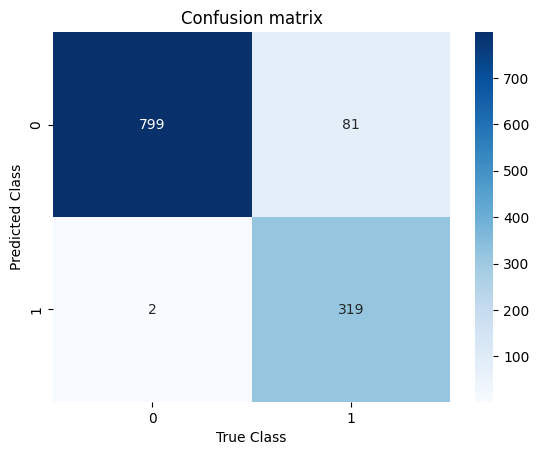

In [84]:
plot_confusion_matrix( test_data_mae['prediction'] , test_data_mae['fault_type'])

###  FAR and FDR

In [28]:
len(test_data_mae[test_data_mae.fault_type == 1])

400

In [29]:
cf_matrix = confusion_matrix( test_data_mae['prediction'] , test_data_mae['fault_type'] )
cf_matrix

array([[799,  81],
       [  2, 319]])

In [30]:
def FDR_FAR(cf_matrix):
#     TP = cf_matrix[0][0]
#     TN = cf_matrix[1][1]
#     FN = cf_matrix[0][1]
#     FP = cf_matrix[1][0]
    TP = cf_matrix[1][1]
    TN = cf_matrix[0][0]
    FN = cf_matrix[0][1]
    FP = cf_matrix[1][0]
    FAR = FP / (FP + TN)
    #FDR = (TP + TN) / (TP + TN + FN + FP)
    FDR = (TP) / (TP + FN)
    
    return FDR*100 , FAR*100 , TP ,TN , FP ,FN

In [31]:
FDR , FAR , _ , _ , _ , _ = FDR_FAR(cf_matrix)
FDR , FAR

(79.75, 0.24968789013732834)

### visualize reconstruction loss

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


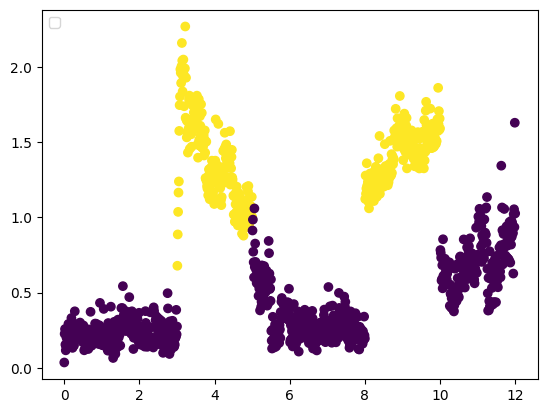

In [32]:
#plt.plot(test_data_mae[test_data_mae.fault_type == 1]['Time'] , test_data_mae[test_data_mae.fault_type == 1]['loss'])
fig = plt.figure()
ax1 = fig.add_subplot(111)

#ax1.scatter(test_data_mae.Time, test_data_mae.fault_type)
ax1.scatter(test_data_mae["Time"],test_data_mae["loss"],c=test_data_mae["fault_type"])
plt.legend(loc='upper left')
plt.show()

In [33]:
#plt.plot(test_data_mae['Time'] , test_data_mae['loss'])
test_data_mae.shape

(1201, 50)

## plot result against real value over the time

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


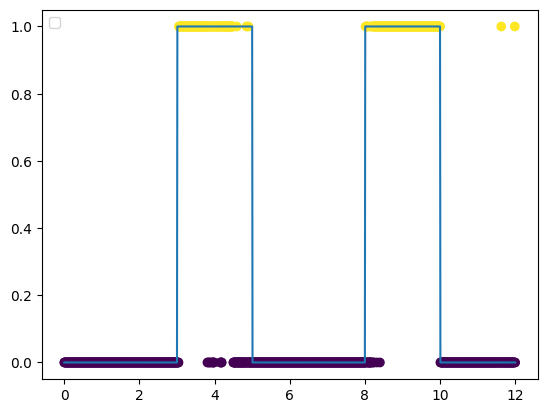

In [34]:
import matplotlib.pyplot as plt

x = range(100)
y = range(100,200)
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(test_data_mae.Time, test_data_mae.fault_type)
ax1.scatter(test_data_mae.Time,test_data_mae.prediction,c=test_data_mae.prediction)
plt.legend(loc='upper left')
plt.show()

# Explainability

## local explainability

In [35]:
test_data_mae = pd.read_csv("./data/TE_fault_detection/preprocesed/test_simulated_data.csv")

In [36]:
test_data_mae[test_data_mae.fault_type == 1]

,Time,Stream9Valve,Stream10Valve,Stream11Valve,ReactorcCoolingWaterValve,CondenserCoolingWaterValve,Stream1,Stream2,Stream3,Stream4,...,Stream9E,Stream9F,Stream9G,Stream9H,Stream11D,Stream11E,Stream11F,Stream11G,Stream11H,fault_type
301,3.01,0.384434,0.206487,0.654184,0.427255,0.295587,0.987306,0.488462,0.599660,0.509968,...,0.137970,0.672642,0.815235,0.757296,0.142804,0.119834,0.510632,0.068091,0.326696,1
302,3.02,0.422496,0.285687,0.497924,0.485105,0.482741,0.981284,0.600254,0.493106,0.334431,...,0.137970,0.672642,0.815235,0.757296,0.142804,0.119834,0.510632,0.068091,0.326696,1
303,3.03,0.350428,0.470774,0.410764,0.589253,0.420956,0.978652,0.370596,0.481612,0.324703,...,0.137970,0.672642,0.815235,0.757296,0.142804,0.119834,0.510632,0.068091,0.326696,1
304,3.04,0.366897,0.308833,0.751951,0.692180,0.390905,0.982946,0.291097,0.406124,0.311559,...,0.137970,0.672642,0.815235,0.757296,0.142804,0.119834,0.510632,0.068091,0.326696,1
305,3.05,0.261362,0.405150,0.690476,0.759899,0.502898,0.987644,0.381156,0.518433,0.636335,...,0.137970,0.672642,0.815235,0.757296,0.142804,0.119834,0.510632,0.068091,0.326696,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,4.96,0.361797,0.238063,0.366033,0.806150,0.380903,0.981870,0.612661,0.405251,0.572535,...,0.106882,0.927868,0.954196,0.935870,0.347425,0.019506,0.917147,0.177956,0.835006,1
497,4.97,0.327344,0.466479,0.488571,0.804331,0.245036,0.979544,0.436584,0.533437,0.504887,...,0.106882,0.927868,0.954196,0.935870,0.347425,0.019506,0.917147,0.177956,0.835006,1
498,4.98,0.346109,0.361325,0.606725,0.802456,0.288878,0.980280,0.398051,0.385193,0.299686,...,0.106882,0.927868,0.954196,0.935870,0.347425,0.019506,0.917147,0.177956,0.835006,1
499,4.99,0.337272,0.524442,0.611801,0.806275,0.452406,0.989598,0.403323,0.279205,0.206682,...,0.106882,0.927868,0.954196,0.935870,0.347425,0.019506,0.917147,0.177956,0.835006,1


In [37]:
# time_to_explain = 350
# test_data_mae.iloc[time_to_explain].to_frame().T

In [38]:
# explain only one occurence of fault
def local_explaination(X,iteration_limit=2000,find_individual_contribution = False,id_features_to_analyse=None):
    data_loader = create_dataset(X.to_frame().T,batch_size=1)
    for in_data , _ in data_loader :
        input_data = in_data
    # with requires_grad=True we tell to pytorch that we need the partial derivative of the input to make the input learnable
    
    if find_individual_contribution :
        binary_mask = torch.zeros_like(input_data)
        binary_mask[0][id_features_to_analyse].fill_(1.)
        fixed_value = (input_data.detach()*binary_mask.logical_not() )
        x = input_data * binary_mask
        x = torch.nn.Parameter(x , requires_grad=True) 
    else :
        x = torch.nn.Parameter(input_data, requires_grad=True) 

    # we want to optimize only the input 
    optim = torch.optim.Adam([x], lr=1e-3) 
    
    # iteration limit is useful to break learning phase when the value of loss function doesn't reach the predefined threshold 
    #iteration_limit = 50
    thresold = 0.005
    #normal_model = model.model(x)[0]
    
    while True :
        # we use the autoencoder who encode normal data for explaination
        #print((x*binary_mask)+fixed_value)
        if find_individual_contribution :
            #print((x*binary_mask)+fixed_value)
            x_hat = model.model((x*binary_mask)+fixed_value)[0]
            loss = criterion((x*binary_mask)+fixed_value,x_hat,model.model,model_type=model.mode)
            fixed_value = (x_hat.detach()*binary_mask.logical_not() )
        else :
            x_hat = model.model(x)[0]
            loss = criterion(x,x_hat,model.model,model_type=model.mode)
        optim.zero_grad()
        # backpropagation step => it compute all partial derivative of Loss function by input through all wieghts and bias
        loss.backward()
        if abs(loss) < thresold or iteration_limit == 0 :
            break
        # optimization step using Adam optimizer defined at the top
        optim.step() 
        iteration_limit-=1
    #print("final loss : {}".format(loss.detach()))
    if find_individual_contribution :
        res = x_hat[0].detach().numpy().tolist()
        print("id features {} ==> loss {}".format(id_features_to_analyse,loss) )
    else :
        res = x[0].detach().numpy().tolist()
    return res

In [39]:
#list(zip(causality_matrix[0],causality_matrix[1]))

In [40]:
from sklearn.preprocessing import StandardScaler , MinMaxScaler , RobustScaler

data_train = pd.read_csv("./data/TE_fault_detection/preprocesed/train_simulated_data_before_scale.csv")
data_train = data_train # get only the normal class in training data for normalization 

def show_local_explaination(list_to_explain,
                      original_data_point,
                      invert_transform,
                      impact_pourcentage = 50 ,
                      plot=False,
                      sort=False,
                      show_pourcentage=False,
                      gettop_x=False,
                      show_green_line = True,
                      savefig=""):
    exp_data = pd.DataFrame(list_to_explain)
    exp_data = exp_data.T
    exp_data.columns = test_data_mae.columns[1:-1]
    col_to_scale = list(data_train.columns)[1:-1]
    if invert_transform :
        scaler = MinMaxScaler()
        scaler.fit(data_train[col_to_scale])
        exp_inverted = pd.DataFrame()
        org_inverted = pd.DataFrame()
        exp_inverted[col_to_scale] = scaler.inverse_transform(exp_data[col_to_scale])
        org_inverted[col_to_scale] = scaler.inverse_transform(original_data_point[col_to_scale])

        result = pd.concat([org_inverted,exp_inverted]).T
    else :
        result = pd.concat([original_data_point[col_to_scale],exp_data[col_to_scale]]).T
        
    result.columns = ['real_data_point','optimal_values']
    result['impact'] = result[result.columns].apply(lambda x  : x[0] - x[1] , axis=1)
    result = result.fillna(0)
    #full_deviation = result.impact.abs().sum()
    result['pourcentage_impact'] = result['impact'].apply(lambda x : (abs(x)/result.impact.abs().sum())*100 )
    
    result['deviation_proportion'] = result[['impact','optimal_values']].apply(lambda x : (abs(x['impact'])/abs(x['optimal_values']))*100, axis=1)
    result_copy = result.sort_values(by=['pourcentage_impact'],ascending=False)
    result_copy['pourc_cum'] = result_copy.pourcentage_impact.cumsum()
    impacting_variable_index = list(np.where(result_copy['pourc_cum'] > impact_pourcentage))[0][0]
    impacting_variable_line = (len(result) - impacting_variable_index ) - 1.5
    
    # rename several column for a proper display
    result = result.rename(index={"ReactorCoolingWaterOutletTemperature":"ReacCoolWaterOutTemp",
                                  "CondenserCoolingWaterOutletTemperature":"CondCoolWaterOutTemp",
                                  "ReactorcCoolingWaterValve":"ReactorCoolingWaterValve"})
    if sort :
            if gettop_x :
                result.sort_values(by=['pourcentage_impact'],ascending=False , inplace=True)
                result = result[0:10]
                impacting_variable_line = (len(result) - impacting_variable_index ) - 1.5
            result.sort_values(by=['pourcentage_impact'],ascending=True , inplace=True)
    if plot :
        limit = np.max(np.abs(result.impact.values)) 
#         limit = limit + 0.2*limit
        if gettop_x :
            fig, ax = plt.subplots(figsize=(4,3))
        else :
            fig, ax = plt.subplots(figsize=(4,10))
        ax.set_xlim([-limit*1.6,limit*1.3])
        ax.barh(result.index, result['impact'], color='blue')
        container = ax.containers[0]
        if show_pourcentage :
            ax.bar_label(container, labels=[f'{x:,.2f} %' for x in list(result.pourcentage_impact)])
        
        if show_green_line :
            ax.plot([-1, 1], [impacting_variable_line, impacting_variable_line], "k--",color='green')
    
        if show_pourcentage :
            ax.set_xlabel("deviation")
        else :
            ax.set_xlabel(" normalized deviation")
        ax.set_ylabel("features")
        
        if len(savefig) > 0 :
            fig.savefig("{}.png".format(savefig))
    else :
        result.sort_values(by=['pourcentage_impact'],ascending=False , inplace=True)
        return result , impacting_variable_index

/tmp/ipykernel_1007/4245318726.py:67: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([-1, 1], [impacting_variable_line, impacting_variable_line], "k--",color='green')


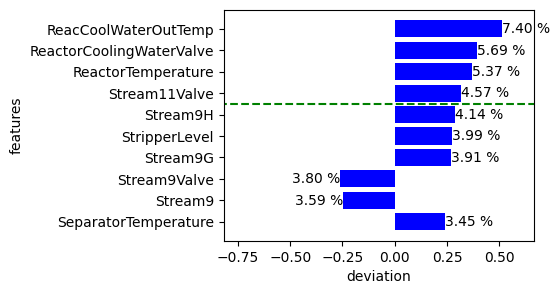

In [41]:
time_to_explain = 375
original = test_data_mae.iloc[time_to_explain].to_frame().T  # pick on point among 
x_reconstructed = local_explaination(test_data_mae.iloc[time_to_explain],iteration_limit=2000)
exp=show_local_explaination(x_reconstructed,original,invert_transform=False,impact_pourcentage=20,plot=True,sort=True,gettop_x=True,show_pourcentage=True)

/tmp/ipykernel_1007/4245318726.py:67: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([-1, 1], [impacting_variable_line, impacting_variable_line], "k--",color='green')


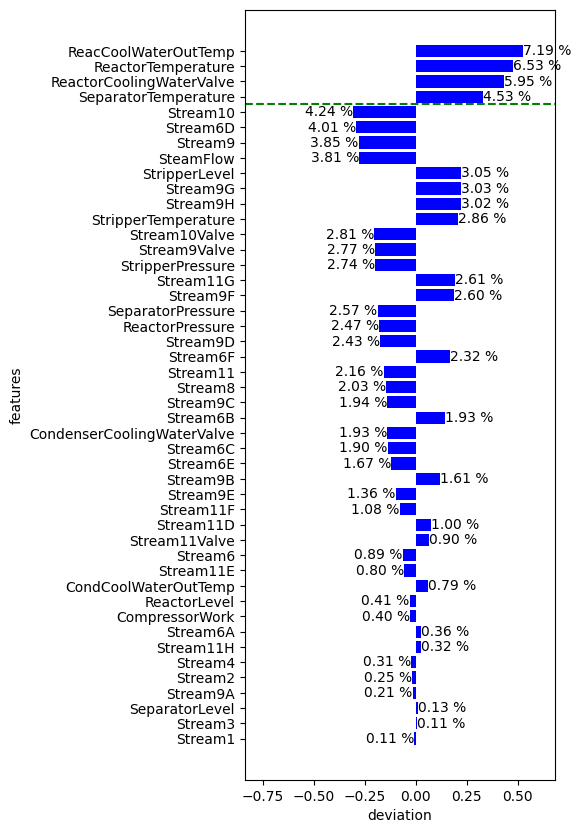

In [42]:
time_to_explain = 345
original = test_data_mae.iloc[time_to_explain].to_frame().T  # pick on point among 
x_reconstructed = local_explaination(test_data_mae.iloc[time_to_explain],iteration_limit=2000)
show_local_explaination(x_reconstructed,original,invert_transform=False,impact_pourcentage=20,plot=True,sort=True,show_pourcentage=True)

In [43]:
show_local_explaination(x_reconstructed,original,invert_transform=False,impact_pourcentage=20,plot=False,sort=True,show_pourcentage=True)[0][0:3]

,real_data_point,optimal_values,impact,pourcentage_impact,deviation_proportion
ReacCoolWaterOutTemp,0.890872,0.366522,0.524350,7.191466,143.060991
ReactorTemperature,0.838463,0.362476,0.475987,6.528173,131.315517
ReactorCoolingWaterValve,0.860441,0.426881,0.433560,5.946286,101.564714


/tmp/ipykernel_1007/4245318726.py:67: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([-1, 1], [impacting_variable_line, impacting_variable_line], "k--",color='green')


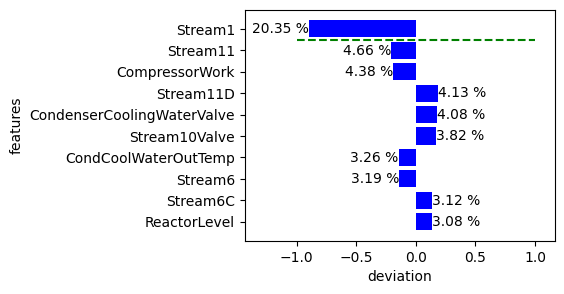

In [44]:
time_to_explain = 870
original = test_data_mae.iloc[time_to_explain].to_frame().T  # pick on point among 
x_reconstructed = local_explaination(test_data_mae.iloc[time_to_explain],iteration_limit=2000)
show_local_explaination(x_reconstructed,original,invert_transform=False,impact_pourcentage=20,plot=True,sort=True,show_pourcentage=True,gettop_x=True)

/tmp/ipykernel_1007/4245318726.py:67: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([-1, 1], [impacting_variable_line, impacting_variable_line], "k--",color='green')


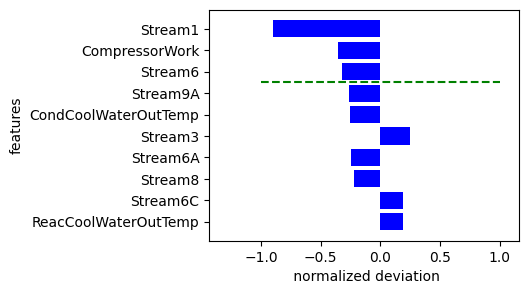

In [45]:
time_to_explain = 950
original = test_data_mae.iloc[time_to_explain].to_frame().T  # pick on point among 
x_reconstructed = local_explaination(test_data_mae.iloc[time_to_explain],iteration_limit=6000)
show_local_explaination(x_reconstructed,original,invert_transform=False,impact_pourcentage=20,plot=True,gettop_x=True,sort=True,show_pourcentage=False)

In [46]:
#show_explaination(x_reconstructed,original,invert_transform=False,impact_pourcentage=50,plot=True,sort=True,show_pourcentage=True)

## Global explainability

In [1015]:
def global_explaination(X,learn_input=False):
    data_loader = create_dataset(X.to_frame().T,batch_size=1)
    for in_data , _ in data_loader :
        x = in_data
    x = torch.nn.Parameter(x, requires_grad=True)
    optim = torch.optim.Adam([x], lr=1e-3)
    iteration_limit = 3000
    while True :
        x_hat = model.model(x)[0]
        loss = criterion(x,x_hat,model.model,model_type="VAE")
        optim.zero_grad()
        loss.backward()
        if abs(loss) < 0.005 or iteration_limit == 0 or not learn_input:
            break
        if learn_input :
            optim.step()
            iteration_limit-=1
        
    if learn_input :
        res = list(x_hat.detach().numpy()[0])
    else :
        res = list(x.grad.detach().numpy()[0])
        
    return pd.Series(res)

In [1105]:
test_data_fault1 = test_data_mae[test_data_mae.fault_type == 2]
test_data_fault1

,Time,Stream9Valve,Stream10Valve,Stream11Valve,ReactorcCoolingWaterValve,CondenserCoolingWaterValve,Stream1,Stream2,Stream3,Stream4,...,Stream9E,Stream9F,Stream9G,Stream9H,Stream11D,Stream11E,Stream11F,Stream11G,Stream11H,fault_type
801,8.01,0.309457,0.300155,0.754571,0.413204,0.259388,0.011456,0.520221,0.644232,0.464670,...,0.191936,0.670759,0.702511,0.568593,0.483946,0.121396,0.647155,0.374431,0.634166,2
802,8.02,0.335581,0.250393,0.451287,0.408148,0.418066,0.021906,0.082702,0.395139,0.375508,...,0.191936,0.670759,0.702511,0.568593,0.483946,0.121396,0.647155,0.374431,0.634166,2
803,8.03,0.396227,0.232851,0.478193,0.409456,0.593511,0.018198,0.574778,0.499315,0.722941,...,0.191936,0.670759,0.702511,0.568593,0.483946,0.121396,0.647155,0.374431,0.634166,2
804,8.04,0.296781,0.668166,0.464626,0.406390,0.445198,0.020789,0.426566,0.729554,0.632173,...,0.191936,0.670759,0.702511,0.568593,0.483946,0.121396,0.647155,0.374431,0.634166,2
805,8.05,0.329180,0.292513,0.732030,0.394294,0.387817,0.005888,0.662495,0.761887,0.616827,...,0.191936,0.670759,0.702511,0.568593,0.483946,0.121396,0.647155,0.374431,0.634166,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,9.96,0.755937,0.496020,0.527257,0.186277,0.274458,0.015244,0.300698,0.478764,0.512774,...,0.516720,0.567683,0.463770,0.414369,0.279017,0.302276,0.621960,0.601152,0.448655,2
997,9.97,0.589917,0.268047,0.531029,0.179059,0.183895,0.014162,0.504858,0.499285,0.534440,...,0.516720,0.567683,0.463770,0.414369,0.279017,0.302276,0.621960,0.601152,0.448655,2
998,9.98,0.761382,0.201834,0.368586,0.179787,0.452737,0.016262,0.578957,0.588450,0.118220,...,0.516720,0.567683,0.463770,0.414369,0.279017,0.302276,0.621960,0.601152,0.448655,2
999,9.99,0.729563,0.437883,0.242520,0.181556,0.695890,0.013659,0.616838,0.527556,0.374023,...,0.516720,0.567683,0.463770,0.414369,0.279017,0.302276,0.621960,0.601152,0.448655,2


In [1106]:
fault1_deviation = pd.DataFrame()
col_util = train_data_fault1.columns
col_explaination = [col for col in col_util[1:-1]]
fault1_deviation[col_explaination] = test_data_fault1[col_util].apply(lambda data  : global_explaination(data,learn_input=True), axis=1)

In [1107]:
deviation =  test_data_fault1[list(train_data_fault1)[1:-1]] - fault1_deviation

In [1108]:
deviation

,Stream9Valve,Stream10Valve,Stream11Valve,ReactorcCoolingWaterValve,CondenserCoolingWaterValve,Stream1,Stream2,Stream3,Stream4,Stream8,...,Stream9D,Stream9E,Stream9F,Stream9G,Stream9H,Stream11D,Stream11E,Stream11F,Stream11G,Stream11H
801,-0.083338,-0.128047,0.242567,0.003661,-0.108565,-0.954517,0.054843,0.149468,-0.025650,-0.014653,...,0.033754,0.044175,0.025075,0.006333,-0.084599,0.057709,0.004747,-0.232833,0.001581,-0.056844
802,-0.057993,-0.172517,-0.069218,-0.001990,0.054886,-0.944228,-0.374046,-0.080811,-0.071210,0.010981,...,0.031743,0.043740,0.024223,0.008065,-0.083069,0.047173,0.003698,-0.248439,-0.009055,-0.047306
803,0.003237,-0.195257,-0.030019,-0.000239,0.224311,-0.947896,0.105738,-0.002002,0.215657,-0.042388,...,0.034552,0.045139,0.023926,0.004802,-0.086040,0.061719,0.006039,-0.227292,0.003316,-0.059846
804,-0.091504,0.211373,-0.034266,-0.002728,0.063295,-0.947646,-0.061496,0.181830,0.040817,0.023198,...,0.038685,0.043090,0.025728,0.002190,-0.090514,0.098217,0.006252,-0.185972,0.040620,-0.089552
805,-0.065459,-0.128189,0.218369,-0.016429,0.022948,-0.960846,0.199234,0.275876,0.142123,0.138061,...,0.033002,0.045894,0.020630,0.004623,-0.086262,0.053480,0.006393,-0.240329,-0.009596,-0.050518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0.036388,0.086264,0.109135,-0.111924,-0.174644,-0.910211,-0.111857,0.126583,0.202853,-0.105047,...,0.021568,0.108414,0.110044,0.076000,0.120044,-0.246567,-0.051640,-0.010157,0.059139,0.035067
997,-0.129631,-0.141708,0.112906,-0.119142,-0.265207,-0.911294,0.092303,0.147104,0.224520,-0.090656,...,0.021568,0.108415,0.110042,0.075998,0.120043,-0.246567,-0.051638,-0.010155,0.059139,0.035067
998,0.041894,-0.207953,-0.049579,-0.118440,0.003633,-0.909206,0.166391,0.236265,-0.191705,-0.121523,...,0.021537,0.108373,0.110102,0.076033,0.120055,-0.246568,-0.051690,-0.010213,0.059009,0.035188
999,0.010094,0.028084,-0.175657,-0.116676,0.246783,-0.911809,0.204270,0.175374,0.064101,-0.105753,...,0.021520,0.108347,0.110137,0.076057,0.120071,-0.246575,-0.051720,-0.010224,0.058960,0.035242


In [1109]:
global_deviation = deviation.mean().to_frame()

In [1110]:
global_deviation.columns = ["impact"]
global_deviation['pourcentage_impact'] = global_deviation.apply(lambda x : (abs(x)/global_deviation.impact.abs().sum())*100)

In [1111]:
global_deviation.sort_values(by=['pourcentage_impact'],ascending=False , inplace=True)

In [1112]:
def show_global_explanation( impact_data ,
                              invert_transform=False,
                              impact_pourcentage = 20 ,
                              plot=False,
                              sort=False,
                              gettop_x=False,
                              show_pourcentage=False):
    result = impact_data
    result = result.fillna(0)
    #full_deviation = result.impact.abs().sum()
    result['pourcentage_impact'] = result['impact'].apply(lambda x : (abs(x)/result.impact.abs().sum())*100 )
    
    result_copy = result.sort_values(by=['pourcentage_impact'],ascending=False)
    result_copy['pourc_cum'] = result_copy.pourcentage_impact.cumsum()
    impacting_variable_index = list(np.where(result_copy['pourc_cum'] > impact_pourcentage))[0][0]
    impacting_variable_line = (len(result) - impacting_variable_index ) - 1.5
    
    result = result.rename(index={"ReactorCoolingWaterOutletTemperature":"ReacCoolWaterOutTemp",
                                  "CondenserCoolingWaterOutletTemperature":"CondCoolWaterOutTemp",
                                  "ReactorcCoolingWaterValve":"ReactorCoolingWaterValve"})
    if sort :
            if gettop_x :
                result.sort_values(by=['pourcentage_impact'],ascending=False , inplace=True)
                result = result[0:10]
                impacting_variable_line = (len(result) - impacting_variable_index ) - 1.5
            result.sort_values(by=['pourcentage_impact'],ascending=True , inplace=True)
    if plot :
        limit = np.max(np.abs(result.impact.values)) 
        limit = limit + 0.1*limit
        if gettop_x :
            fig, ax = plt.subplots(figsize=(4,3))
        else :
            fig, ax = plt.subplots(figsize=(4,3))
        #ax.set_xlim([-limit*1.0,limit*1.9])
        #fig, ax = plt.subplots(figsize=(4,10))
        ax.set_xlim([-limit*1.3,limit*0.8])
        ax.barh(result.index, result['impact'], color='blue')
        container = ax.containers[0]
        if show_pourcentage :
            ax.bar_label(container, labels=[f'{x:,.2f} %' for x in list(result.pourcentage_impact)])
        ax.plot([-1, 1], [impacting_variable_line, impacting_variable_line], "k--",color='green')
        ax.set_xlabel("deviation")
        ax.set_ylabel("features")
    else :
        return result

/tmp/ipykernel_1133/2825731310.py:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([-1, 1], [impacting_variable_line, impacting_variable_line], "k--",color='green')


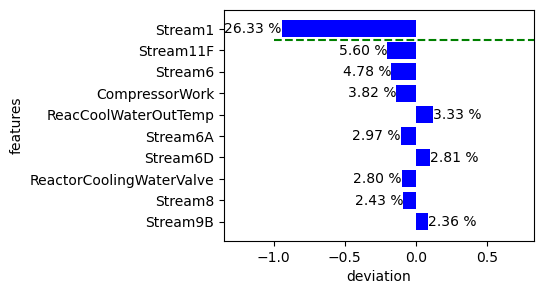

In [1113]:
show_global_explanation(global_deviation,sort=True,plot=True,gettop_x=True,show_pourcentage=True)

/tmp/ipykernel_1133/2614769176.py:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([-1, 1], [impacting_variable_line, impacting_variable_line], "k--",color='green')


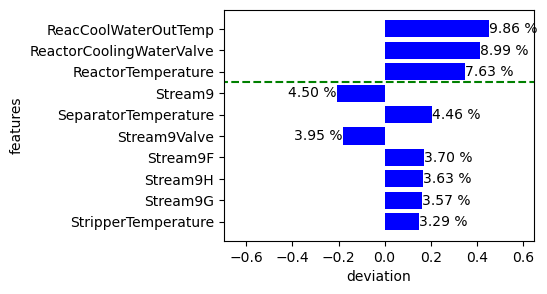

In [1085]:
show_global_explanation(global_deviation,sort=True,plot=True,gettop_x=True,show_pourcentage=True)

/tmp/ipykernel_1133/291533042.py:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([-1, 1], [impacting_variable_line, impacting_variable_line], "k--",color='green')


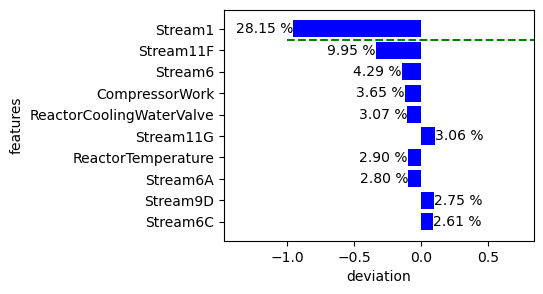

In [1054]:
show_global_explanation(global_deviation,sort=True,plot=True,gettop_x=True,show_pourcentage=True)

# Causality Analysis

In [47]:
from itertools import combinations
import pylab as plt
import networkx as nx
from sklearn.metrics import f1_score

from pgmpy.estimators import PC, HillClimbSearch, ExhaustiveSearch
from pgmpy.estimators import K2Score , BDeuScore , BicScore
from pgmpy.utils import get_example_model
from pgmpy.sampling import BayesianModelSampling

In [48]:
def plot_Bayes_net(model):
    pos = nx.circular_layout(model)
    plt.figure(3,figsize=(12,12)) 
    #nx.draw(model, node_color='#00b4d9', pos=pos, with_labels=True)
    nx.draw_circular( model, with_labels=True, arrowsize=30, node_size=800, alpha=0.3, font_weight="bold")
    plt.show()

In [49]:

def individual_local_explaination(X,X_ref,iteration_limit=2000,find_individual_contribution = True,id_features_to_analyse=None):
    X_dataloader = create_dataset(X.to_frame().T,batch_size=1)
    X_ref_dataloader = create_dataset(X_ref.to_frame().T,batch_size=1)
    for in_data , _ in X_dataloader :
        input_data = in_data
    for ref_data , _ in X_ref_dataloader :
        ref_data = ref_data
    # with requires_grad=True we tell to pytorch that we need the partial derivative of the input to make the input learnable
    
    if find_individual_contribution :
        binary_mask = torch.zeros_like(input_data)
        binary_mask[0][id_features_to_analyse].fill_(1.)
        fixed_value = (input_data.detach()*binary_mask.logical_not() )
        x = input_data * binary_mask
        x = torch.nn.Parameter(x , requires_grad=True) 

    # we want to optimize only the input 
    optim = torch.optim.Adam([x], lr=0.1) 
    
    # iteration limit is useful to break learning phase when the value of loss function doesn't reach the predefined threshold 
    #iteration_limit = 50
    thresold = 0.0005
    #normal_model = model.model(x)[0]
    optim_records = []
    while True :
        # we use the autoencoder who encode normal data for explaination
        if find_individual_contribution :
            x_hat = model.model((x*binary_mask)+fixed_value)[0]
            fixed_x_hat = (x_hat.detach()*binary_mask.logical_not())
            loss = criterion( ref_data ,x_hat,model.model,model_type=model.mode)
            #loss = criterion( (x*binary_mask)+fixed_x_hat ,ref_data,model.model,model_type=model.mode)
            #loss = criterion( ref_data , x_hat,model.model,model_type=model.mode)
            
        # records impact in others features
        if iteration_limit%10 == 0 :
            fixed_x_hat = (x_hat.detach()*binary_mask.logical_not())
            optim_records.append( ((x*binary_mask)+fixed_x_hat)[0].detach().numpy().tolist())
            
        # backpropagation step => it compute all partial derivative of Loss function by input through all wieghts and bias
        if abs(loss) < thresold or iteration_limit == 0 :
            break
        # optimization step using Adam optimizer defined at the top
        optim.zero_grad()
        loss.backward()
        optim.step() 
        iteration_limit-=1
            
    #print("final loss : {}".format(loss.detach()))
    if find_individual_contribution :
        fixed_x_hat = (x_hat.detach()*binary_mask.logical_not())
        res = ((x*binary_mask)+fixed_x_hat)[0].detach().numpy().tolist()
        #print("id features {} ==> loss {}".format(id_features_to_analyse,loss) )
    return res , optim_records

In [50]:
from tqdm import tqdm

def compute_pourcentage(f):
    f = list(f)
    total = sum(f)
    result = list(map(lambda element : round(( element / total )*100) , f))
    return pd.Series(result)
    
def compute_causality_matrix(time_to_explain, test_data , col_to_inspect):
    #time_to_explain = 362
    original = test_data_mae.iloc[time_to_explain].to_frame().T  # pick on point among
    mem_original = original.drop(['Time','fault_type'],axis=1)
    reconstructed_matrix = []
    original_matrix = []
    causality_matrix = []
    original = original.values.tolist()[0][1:-1]
    
    #find global best
    global_relearned = local_explaination(test_data_mae.iloc[time_to_explain],iteration_limit=2000)
    global_relearned.insert(0,0) 
    global_relearned.append(0)
    global_relearned = pd.Series(global_relearned, index=test_data_mae.iloc[time_to_explain].index.tolist())
    
    for idx in tqdm(range(len(list(original)))):
        #if mem_original.columns[idx] in col_to_inspect :
        if True :
            #x_reconstructed = individual_local_explaination(test_data_mae.iloc[time_to_explain],global_relearned,iteration_limit=2000,find_individual_contribution=True,id_features_to_analyse=idx)
            x_reconstructed , recon_records = individual_local_explaination(test_data_mae.iloc[time_to_explain],global_relearned,iteration_limit=2000,find_individual_contribution=True,id_features_to_analyse=idx)
            records = True
            if records:
                for x_reconstructed in recon_records :
                    reconstructed_matrix.append(x_reconstructed) 
                    original = list(global_relearned)[1:-1]
                    original_matrix.append(original)
                    causality_matrix.append([abs(x-recon) for x,recon in zip(original,x_reconstructed)])
            else :
                reconstructed_matrix.append(x_reconstructed)
                original = list(global_relearned)[1:-1]
                original_matrix.append(original)
                causality_matrix.append([abs(x-recon) for x,recon in zip(original,x_reconstructed)])
    
    original = test_data_mae.iloc[time_to_explain].to_frame().T  # pick on point among
    original = list(original)[1:-1]
    #df_causality_matrix = pd.DataFrame(np.array(causality_matrix),columns=list(original)).T
    df_causality_matrix = pd.DataFrame(np.array(causality_matrix),columns=list(original))
    df_causality_matrix.columns = list(original)
    
    df_causality_matrix[list(df_causality_matrix.columns)] = df_causality_matrix.apply(lambda features : compute_pourcentage(features),axis=1)
    df_causality_matrix = df_causality_matrix.astype(int)
    return df_causality_matrix

In [51]:
def find_causal_graph(df_causality_matrix, col_to_inspect, method="score_based"):
    if True :
        data = df_causality_matrix[col_to_inspect]
        scoring_meth = K2Score(data=data)
        est = HillClimbSearch(data, scoring_meth)
        estimated_model = est.estimate(scoring_method=scoring_meth, max_indegree=2, max_iter=int(1e2))
        print(estimated_model)
        return estimated_model
    elif method == "constraint_based" :
        est = PC(data=df_causality_matrix[col_to_inspect])
        estimated_model = est.estimate(variant="stable", max_cond_vars=400)
        return estimated_model
    

In [52]:
col_to_inspect =  ['ReactorcCoolingWaterValve', 'ReactorTemperature', 'Stream9', 'SeparatorTemperature',
                   'ReactorCoolingWaterOutletTemperature' ]

df_causality_matrix = compute_causality_matrix(355, test_data_mae,col_to_inspect)
causal_graph = find_causal_graph(df_causality_matrix,col_to_inspect,method="score-based")

100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [00:50<00:00,  1.11s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

DAG with 5 nodes and 7 edges


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [00:50<00:00,  1.10s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

DAG with 5 nodes and 7 edges


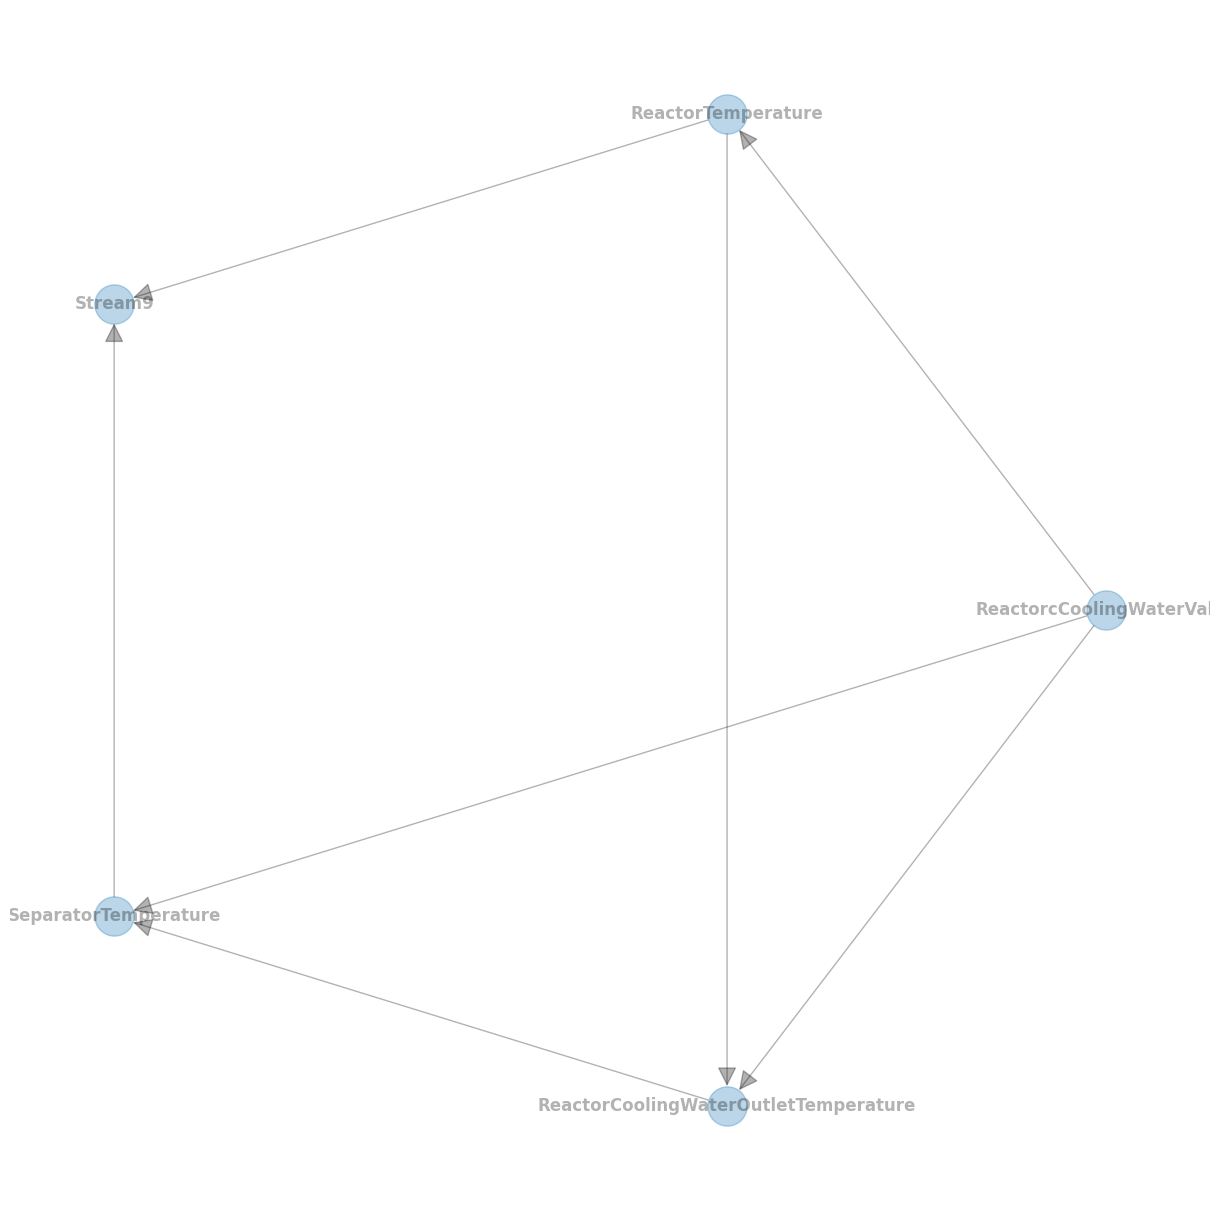

In [53]:
df_causality_matrix = compute_causality_matrix(352, test_data_mae,col_to_inspect)
causal_graph = find_causal_graph(df_causality_matrix,col_to_inspect,method="score-based")
plot_Bayes_net(causal_graph) #352

100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [00:50<00:00,  1.09s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

DAG with 5 nodes and 7 edges


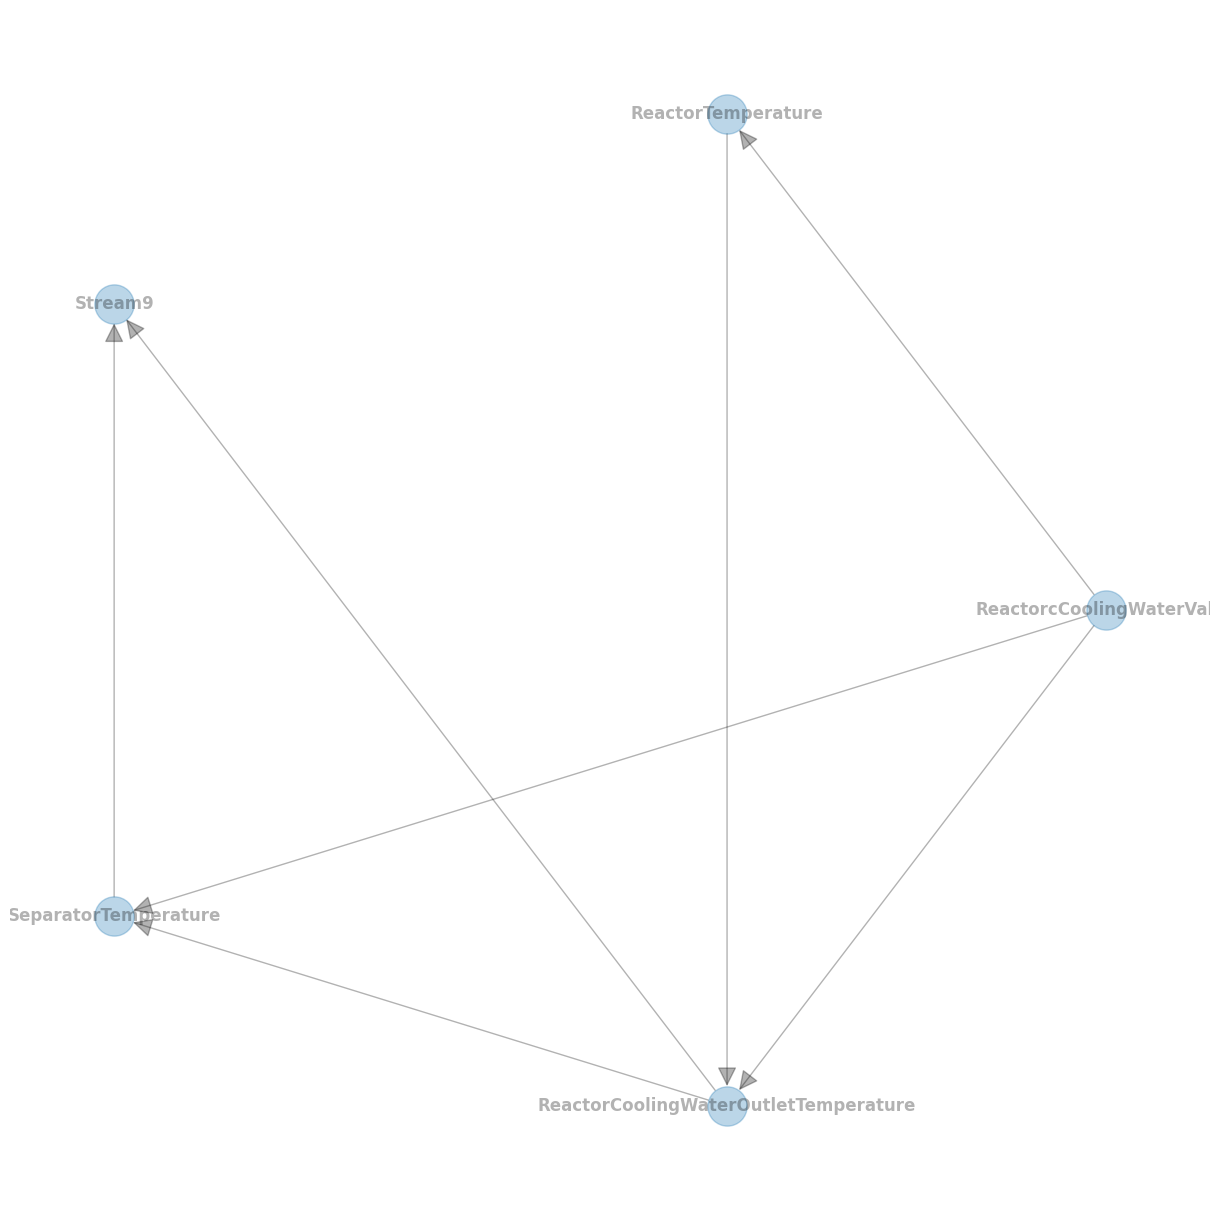

In [54]:
df_causality_matrix = compute_causality_matrix(355, test_data_mae,col_to_inspect)
causal_graph = find_causal_graph(df_causality_matrix,col_to_inspect,method="score-based")
plot_Bayes_net(causal_graph) #355

100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [00:49<00:00,  1.07s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

DAG with 5 nodes and 7 edges


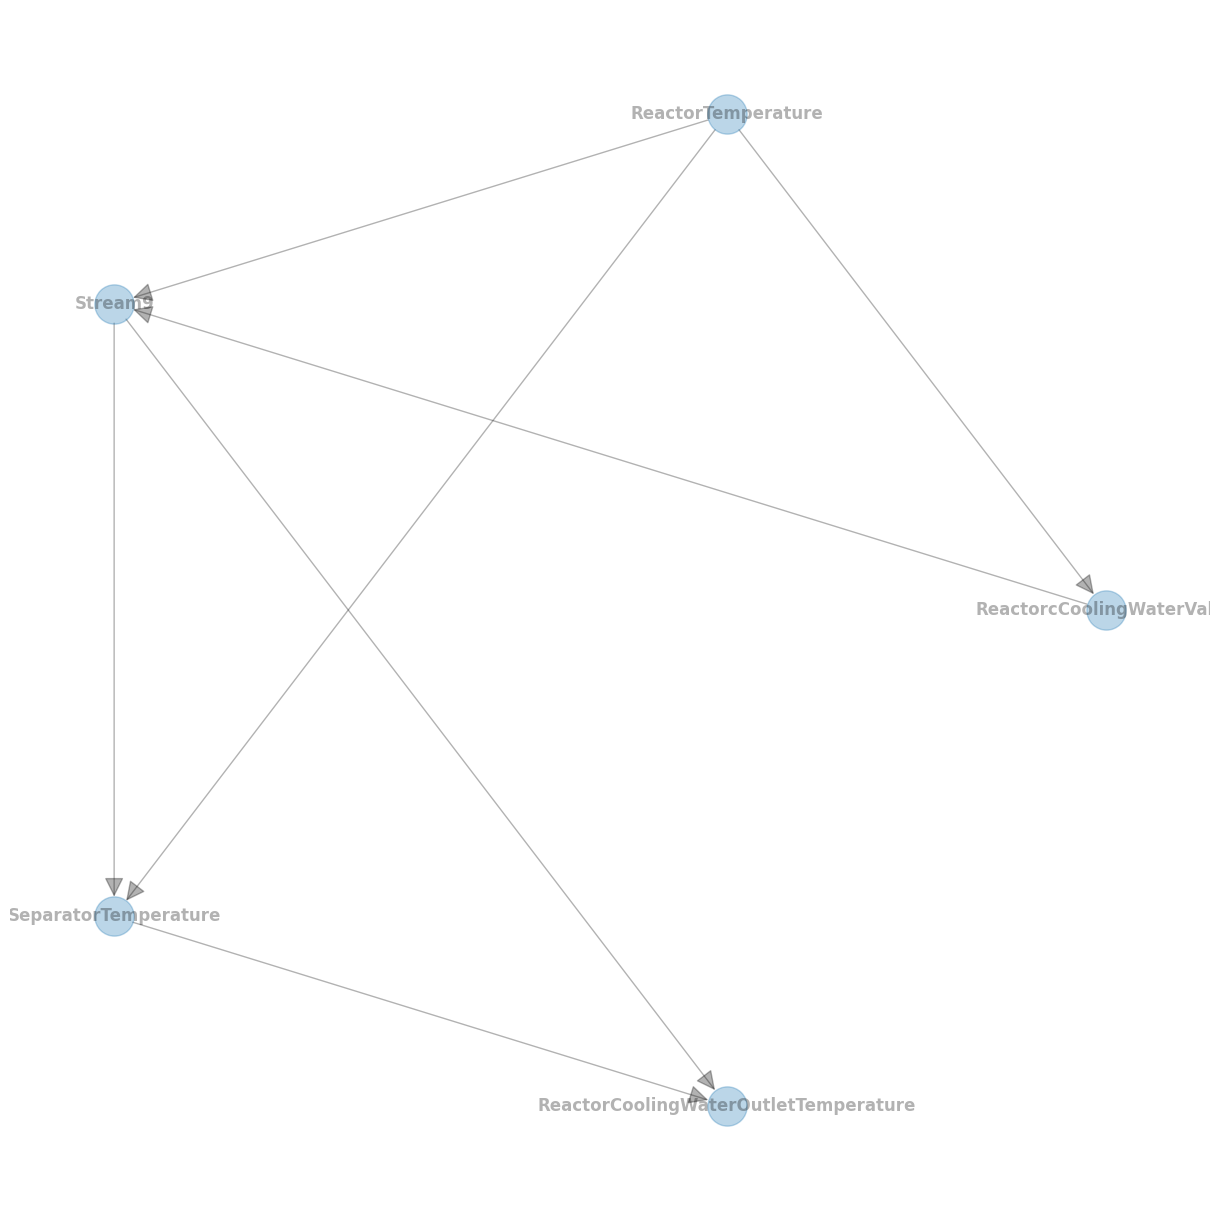

In [55]:
df_causality_matrix = compute_causality_matrix(359, test_data_mae,col_to_inspect)
causal_graph = find_causal_graph(df_causality_matrix,col_to_inspect,method="score-based")
plot_Bayes_net(causal_graph) #359

100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [00:49<00:00,  1.07s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

DAG with 5 nodes and 6 edges


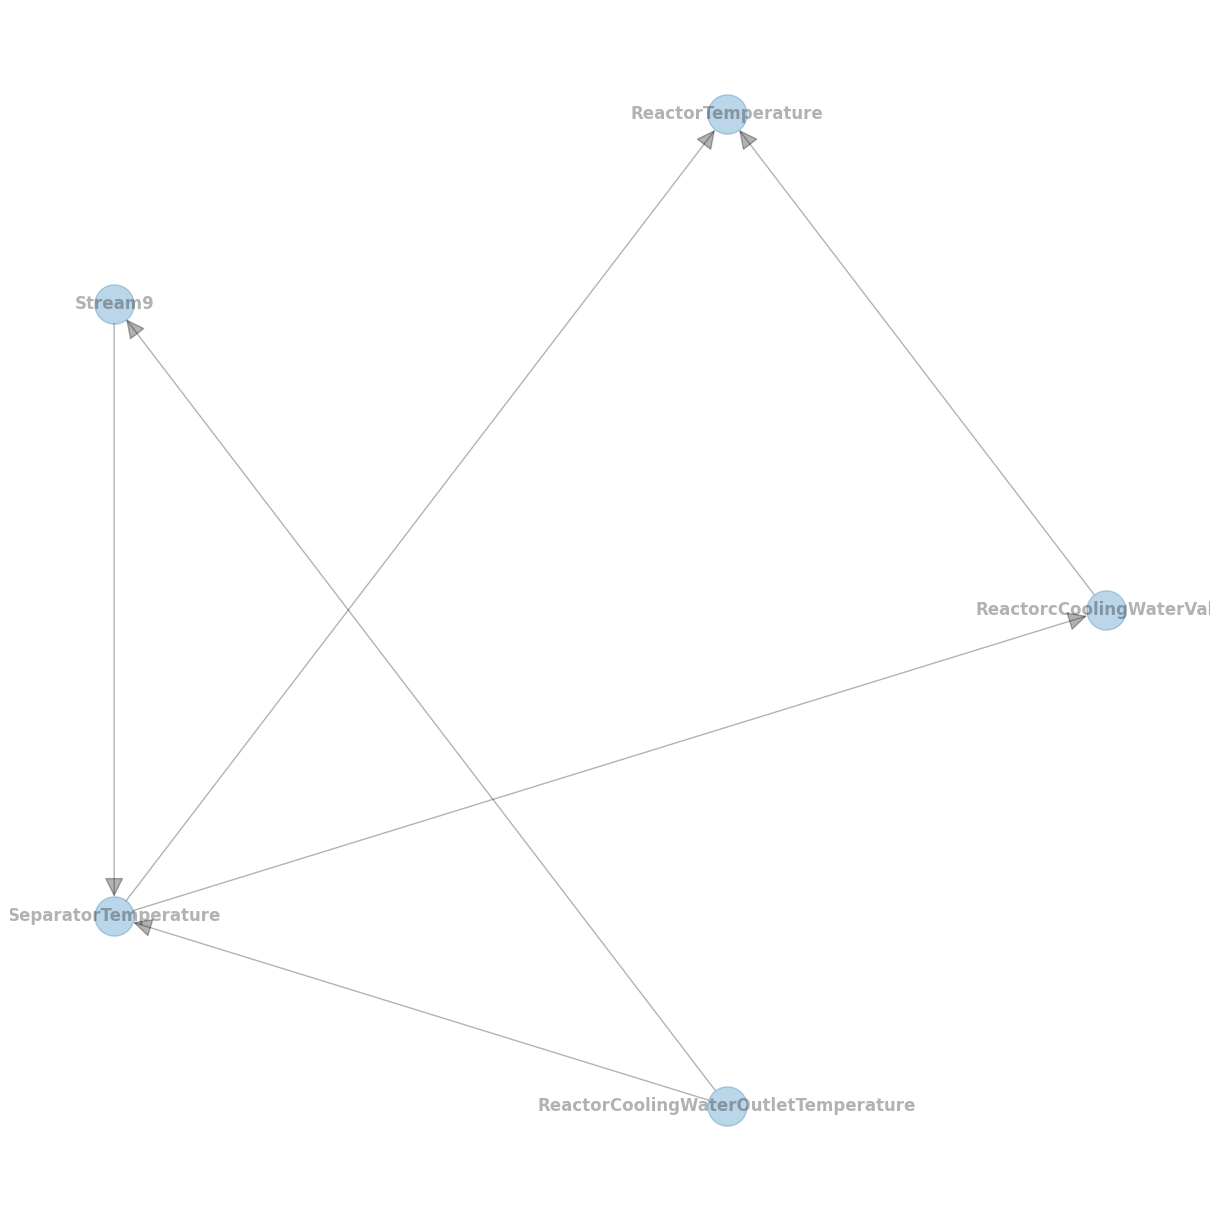

In [56]:
df_causality_matrix = compute_causality_matrix(380, test_data_mae,col_to_inspect)
causal_graph = find_causal_graph(df_causality_matrix,col_to_inspect,method="score-based")
plot_Bayes_net(causal_graph) #380

100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [00:48<00:00,  1.06s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

DAG with 5 nodes and 7 edges


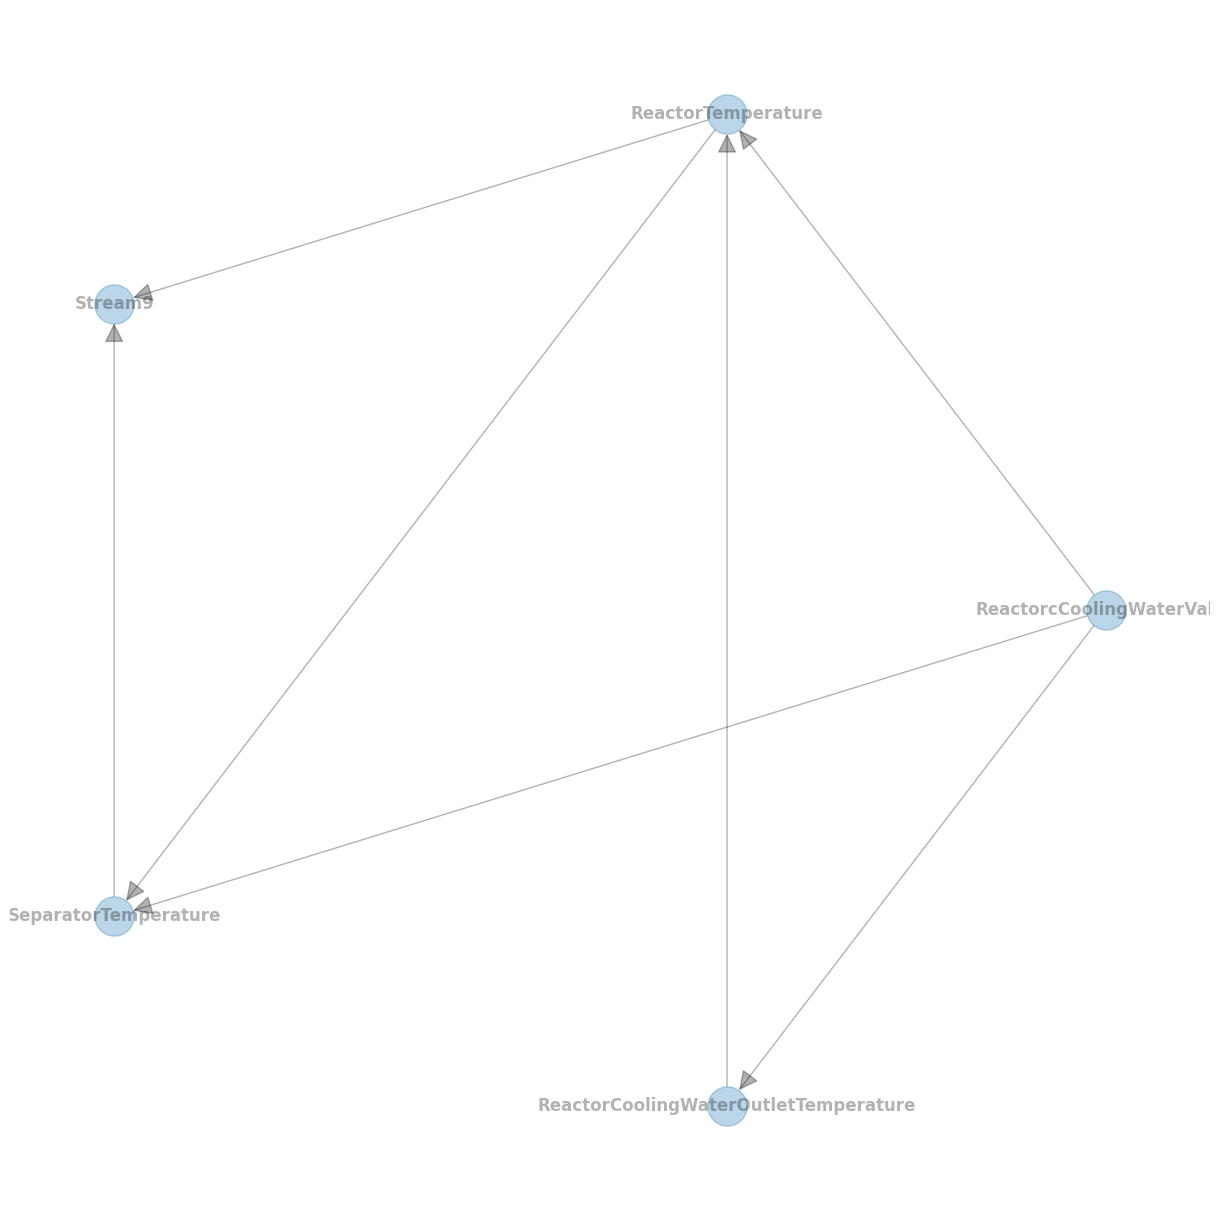

In [57]:
df_causality_matrix = compute_causality_matrix(400, test_data_mae,col_to_inspect)
causal_graph = find_causal_graph(df_causality_matrix,col_to_inspect,method="score-based")
plot_Bayes_net(causal_graph) #400

100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [00:48<00:00,  1.06s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

DAG with 5 nodes and 7 edges


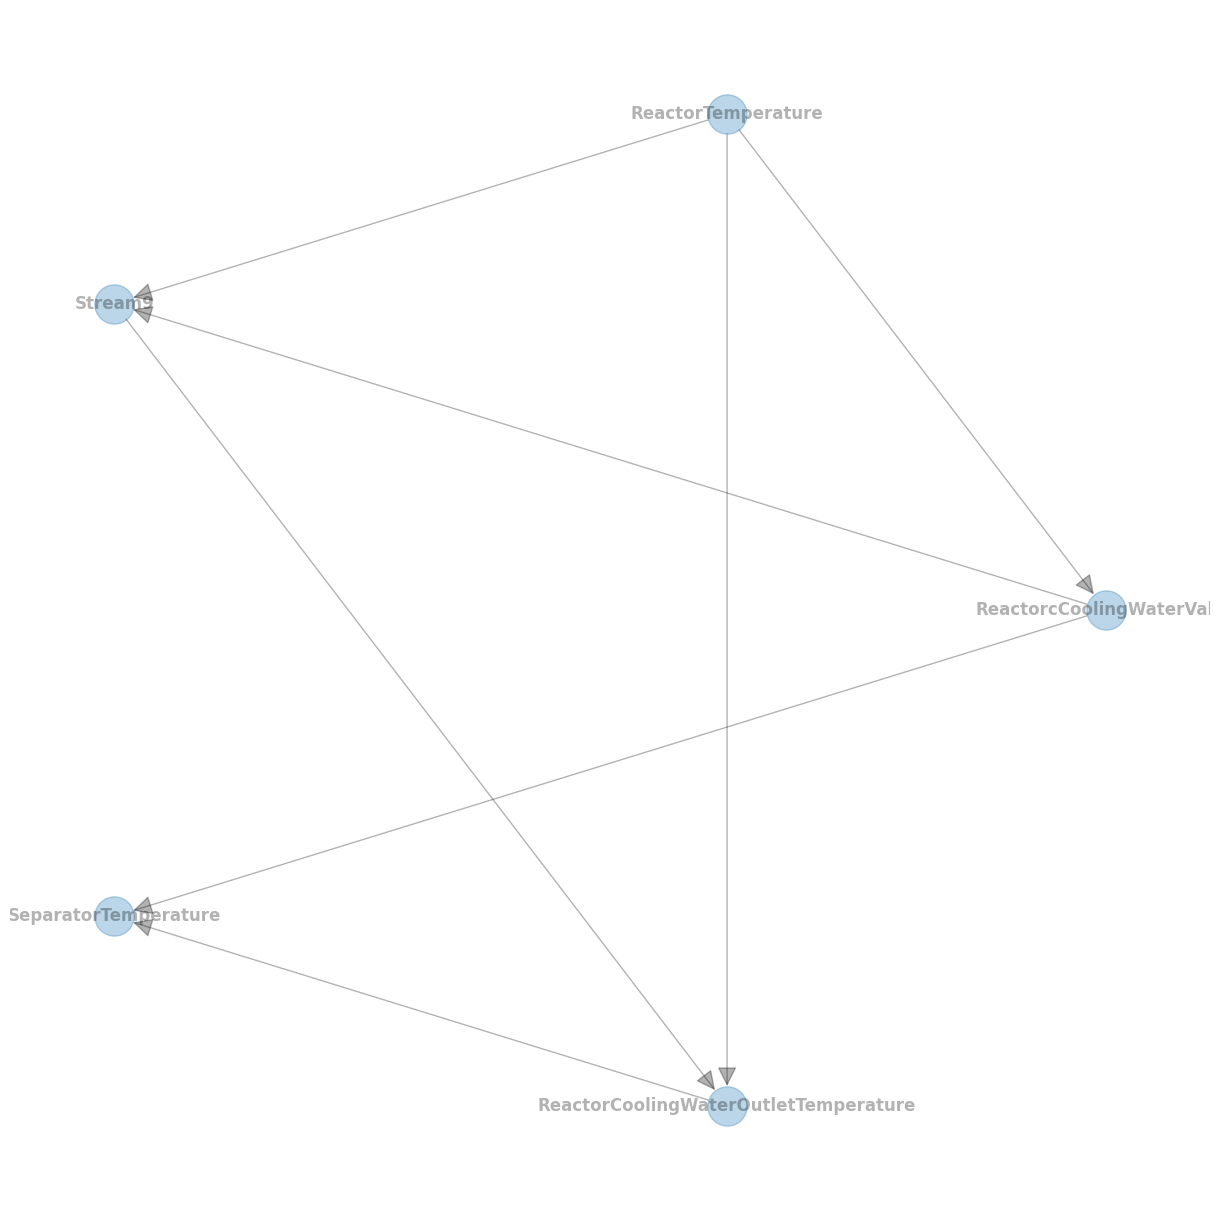

In [58]:
df_causality_matrix = compute_causality_matrix(420, test_data_mae,col_to_inspect)
causal_graph = find_causal_graph(df_causality_matrix,col_to_inspect,method="score-based")
plot_Bayes_net(causal_graph) #420

100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [00:49<00:00,  1.07s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

DAG with 5 nodes and 7 edges


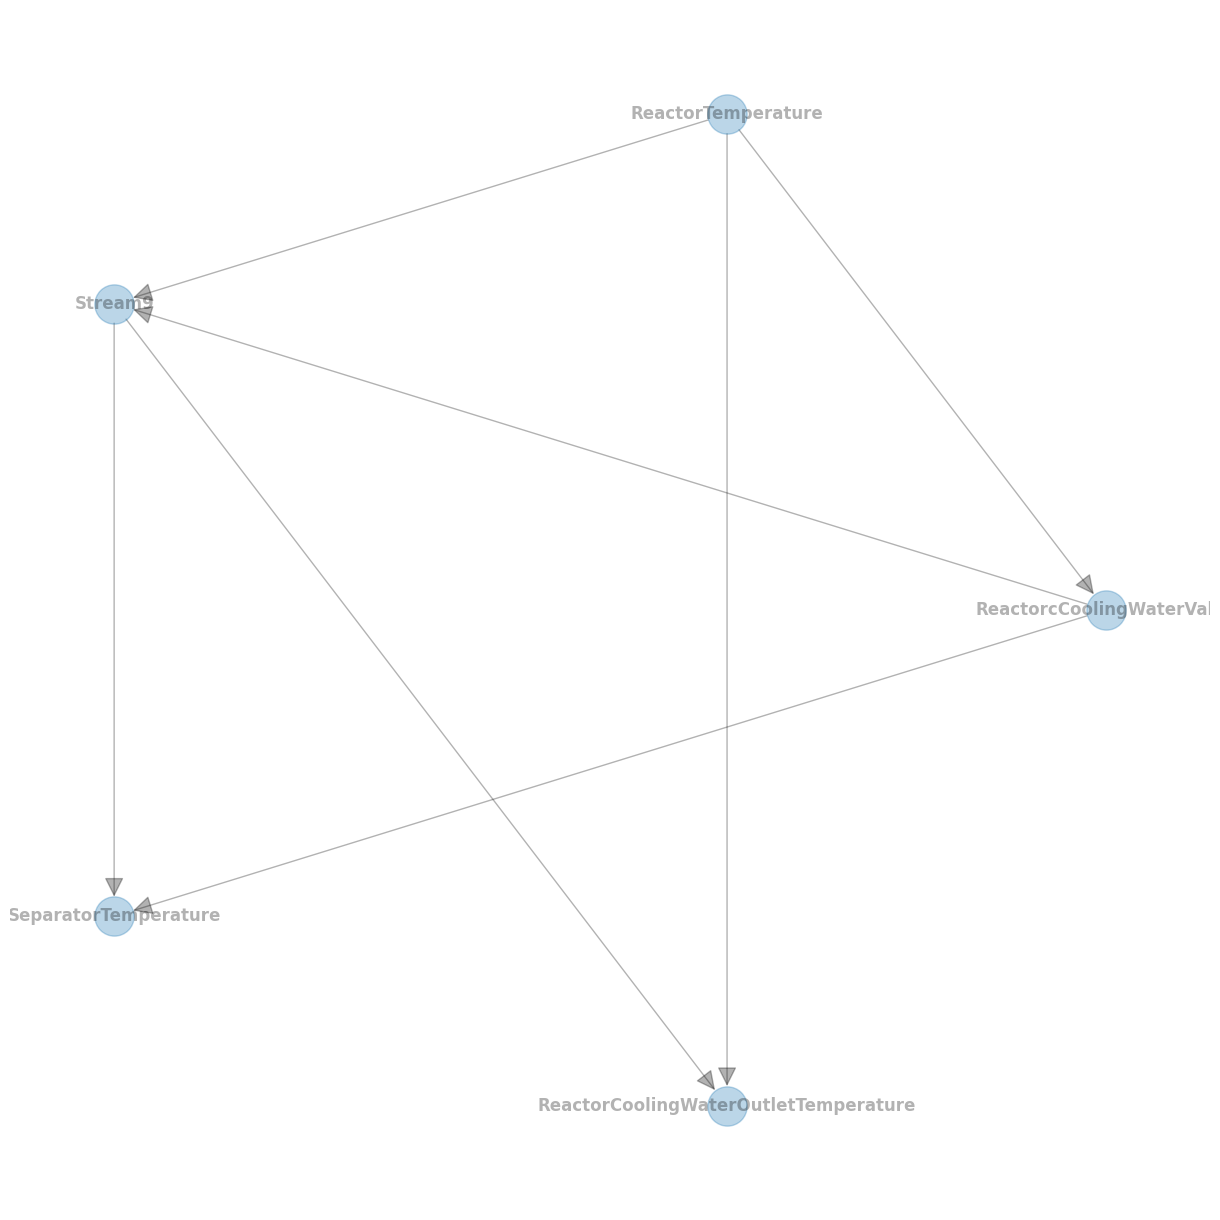

In [59]:
df_causality_matrix = compute_causality_matrix(450, test_data_mae,col_to_inspect)
causal_graph = find_causal_graph(df_causality_matrix,col_to_inspect,method="score-based")
plot_Bayes_net(causal_graph) #450